# Imports 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt


# Model definition

In [2]:
torchvision.models.resnet34()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
class ResBlock(nn.Module):
    """
    Basic Residual block class, each block contains 2 convolutions, batchnorms and ReLU 
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )


    def forward(self, x):
        skip = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = nn.ReLU()(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += skip
        out = nn.ReLU()(out)
        return out


In [4]:
class ResLayer(nn.Module):
    def __init__(self, resblock, in_channels, out_channels, n_blocks, stride=1):
        super(ResLayer, self).__init__()
        strides = [stride] + [1] * (n_blocks - 1)
        self.blocks = nn.Sequential()

        for index, stride in enumerate(strides):
            self.blocks.add_module(f"block{index}", resblock(in_channels, out_channels, stride))
            in_channels = out_channels 
    def forward(self, x):
        return self.blocks(x)

In [5]:
class ResNet(nn.Module):
    def __init__(self, resblock, n_blocks=None, n_classes=10, architecture="18"):
        super(ResNet, self).__init__()
        architecture_presets = {
            "10": [1, 1, 1, 1],
            "18": [2, 2, 2, 2],
            "34": [3, 4, 6, 3]
        }

        if n_blocks is None:
            n_blocks = architecture_presets.get(architecture, [2, 2, 2, 2]) #resnet18 is a default

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = ResLayer(resblock, 64, 64, n_blocks[0], stride=1)
        self.layer2 = ResLayer(resblock, 64, 128, n_blocks[1], stride=2)
        self.layer3 = ResLayer(resblock, 128, 256, n_blocks[2], stride=2)
        self.layer4 = ResLayer(resblock, 256, 512, n_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, n_classes)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Model training and testing

In [6]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 32
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:40<00:00, 4162928.57it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


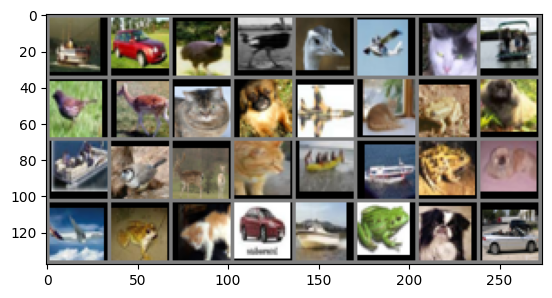

ship  car   bird  bird  bird  plane cat   ship  bird  deer  cat   dog   plane cat   frog  dog   ship  bird  deer  cat   ship  ship  frog  dog   plane frog  cat   car   ship  frog  dog   car  


In [7]:
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [8]:
def train(model, trainloader, device, n_epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    model.to(device)

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0
        for i, data in enumerate(trainloader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if (i + 1) % 100 == 0:
                print(f'Epoch {epoch + 1}, Batch {i + 1}: Loss {running_loss / 100:.3f}')
                running_loss = 0.0

def test(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct // total
    print(f'Accuracy of the network on the test images: {accuracy} %')
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)


In [9]:
device = torch.device('cuda:0')
resnet10 = ResNet(ResBlock, architecture="10")
resnet10.apply(initialize_weights)
resnet18 = ResNet(ResBlock, architecture="18")
resnet18.apply(initialize_weights)
resnet34 = ResNet(ResBlock, architecture="34")
resnet34.apply(initialize_weights)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): ResLayer(
    (blocks): Sequential(
      (block0): ResBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (block1): ResBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [10]:
print("Resnet10 results:")
train(resnet10, trainloader, device, lr=0.001, n_epochs=8)

Resnet10 results:
Epoch 1, Batch 100: Loss 2.020
Epoch 1, Batch 200: Loss 1.797
Epoch 1, Batch 300: Loss 1.729
Epoch 1, Batch 400: Loss 1.655
Epoch 1, Batch 500: Loss 1.617
Epoch 1, Batch 600: Loss 1.562
Epoch 1, Batch 700: Loss 1.478
Epoch 1, Batch 800: Loss 1.486
Epoch 1, Batch 900: Loss 1.423
Epoch 1, Batch 1000: Loss 1.387
Epoch 1, Batch 1100: Loss 1.361
Epoch 1, Batch 1200: Loss 1.383
Epoch 1, Batch 1300: Loss 1.355
Epoch 1, Batch 1400: Loss 1.309
Epoch 1, Batch 1500: Loss 1.291
Epoch 2, Batch 100: Loss 1.251
Epoch 2, Batch 200: Loss 1.245
Epoch 2, Batch 300: Loss 1.240
Epoch 2, Batch 400: Loss 1.213
Epoch 2, Batch 500: Loss 1.207
Epoch 2, Batch 600: Loss 1.196
Epoch 2, Batch 700: Loss 1.192
Epoch 2, Batch 800: Loss 1.186
Epoch 2, Batch 900: Loss 1.153
Epoch 2, Batch 1000: Loss 1.123
Epoch 2, Batch 1100: Loss 1.066
Epoch 2, Batch 1200: Loss 1.132
Epoch 2, Batch 1300: Loss 1.083
Epoch 2, Batch 1400: Loss 1.115
Epoch 2, Batch 1500: Loss 1.073
Epoch 3, Batch 100: Loss 1.023
Epoch 3, 

In [11]:
print("Resnet18 results:")
train(resnet18, trainloader, device, lr=0.001, n_epochs=10)

Resnet18 results:
Epoch 1, Batch 100: Loss 2.103
Epoch 1, Batch 200: Loss 1.832
Epoch 1, Batch 300: Loss 1.826
Epoch 1, Batch 400: Loss 1.717
Epoch 1, Batch 500: Loss 1.684
Epoch 1, Batch 600: Loss 1.632
Epoch 1, Batch 700: Loss 1.535
Epoch 1, Batch 800: Loss 1.576
Epoch 1, Batch 900: Loss 1.538
Epoch 1, Batch 1000: Loss 1.493
Epoch 1, Batch 1100: Loss 1.469
Epoch 1, Batch 1200: Loss 1.449
Epoch 1, Batch 1300: Loss 1.356
Epoch 1, Batch 1400: Loss 1.396
Epoch 1, Batch 1500: Loss 1.355
Epoch 2, Batch 100: Loss 1.344
Epoch 2, Batch 200: Loss 1.284
Epoch 2, Batch 300: Loss 1.312
Epoch 2, Batch 400: Loss 1.273
Epoch 2, Batch 500: Loss 1.258
Epoch 2, Batch 600: Loss 1.184
Epoch 2, Batch 700: Loss 1.251
Epoch 2, Batch 800: Loss 1.229
Epoch 2, Batch 900: Loss 1.228
Epoch 2, Batch 1000: Loss 1.209
Epoch 2, Batch 1100: Loss 1.188
Epoch 2, Batch 1200: Loss 1.152
Epoch 2, Batch 1300: Loss 1.171
Epoch 2, Batch 1400: Loss 1.114
Epoch 2, Batch 1500: Loss 1.147
Epoch 3, Batch 100: Loss 1.127
Epoch 3, 

In [12]:
print("Resnet34 results:")
train(resnet34, trainloader, device, lr=0.0005, n_epochs=15)

Resnet34 results:
Epoch 1, Batch 100: Loss 2.212
Epoch 1, Batch 200: Loss 1.921
Epoch 1, Batch 300: Loss 1.846
Epoch 1, Batch 400: Loss 1.773
Epoch 1, Batch 500: Loss 1.686
Epoch 1, Batch 600: Loss 1.654
Epoch 1, Batch 700: Loss 1.603
Epoch 1, Batch 800: Loss 1.613
Epoch 1, Batch 900: Loss 1.611
Epoch 1, Batch 1000: Loss 1.527
Epoch 1, Batch 1100: Loss 1.472
Epoch 1, Batch 1200: Loss 1.474
Epoch 1, Batch 1300: Loss 1.412
Epoch 1, Batch 1400: Loss 1.451
Epoch 1, Batch 1500: Loss 1.459
Epoch 2, Batch 100: Loss 1.381
Epoch 2, Batch 200: Loss 1.348
Epoch 2, Batch 300: Loss 1.331
Epoch 2, Batch 400: Loss 1.345
Epoch 2, Batch 500: Loss 1.311
Epoch 2, Batch 600: Loss 1.375
Epoch 2, Batch 700: Loss 1.301
Epoch 2, Batch 800: Loss 1.228
Epoch 2, Batch 900: Loss 1.289
Epoch 2, Batch 1000: Loss 1.303
Epoch 2, Batch 1100: Loss 1.234
Epoch 2, Batch 1200: Loss 1.184
Epoch 2, Batch 1300: Loss 1.200
Epoch 2, Batch 1400: Loss 1.220
Epoch 2, Batch 1500: Loss 1.204
Epoch 3, Batch 100: Loss 1.163
Epoch 3, 

In [13]:
test(resnet10, testloader, device)
test(resnet18, testloader, device)
test(resnet34, testloader, device)

Accuracy of the network on the test images: 76 %
Accuracy of the network on the test images: 79 %
Accuracy of the network on the test images: 79 %


Cuda speeds the process drastically, If I used CPU for this it would have taken a minimum of 30 minutes for each of the models